In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# EDA

In [48]:
train_data = pd.read_json("../data/poetry_data_train.json")
test_data = pd.read_json("../data/poetry_data_test.json")

display(train_data.head(3))
display(test_data.head(3))

print("Размер обучающей выборки: %s\nРазмер тестовой выборки: %s" % (len(train_data), len(test_data)))

,url,rating,views,output_text,genre
0,https://www.chitalnya.ru/work/3180020/,29,33,Люблю ли осень? Ты спроси у ели -\nОна в колюч...,лирика
1,https://www.chitalnya.ru/work/2496512/,0,29,Подруга - злая похмелюга\nУжасно вредная порой...,юмор
2,https://www.chitalnya.ru/work/2300891/,73,110,На качелях настроенья\nМы сегодня улетели\nВ р...,лирика


,url,rating,views,output_text,genre
0,https://www.chitalnya.ru/work/2999707/,0,15,"Нынче головы четыре у дракона,\nПожиратель пре...",лирика
1,https://www.chitalnya.ru/work/1026761/,0,167,Сало Украине! Героям - Сало!\nЭтого продукта-д...,юмор
2,https://www.chitalnya.ru/work/2260544/,7,62,"Стая птиц летит по небосводу,\nЗа собою, в про...",лирика


Размер обучающей выборки: 138396
Размер тестовой выборки: 34599


In [49]:
print("Соотношение трейна и теста:", len(train_data) / (len(train_data) + len(test_data)))

Соотношение трейна и теста: 0.8


В дампе есть следующая информация:
- url - ссылка на стих;
- rating - числовое значение, которое соответствует рейтингу стиха (меньше - хуже);
- views - количество просмотров стиха;
- output_text - текст стиха;
- genre - жанр стиха.

Первые мысли, которые возникают:
1. Количество просмотров можно попробовать использовать как дополнительную информацию, чтобы а) не учитывать объекты, с очень низким количеством просмотров б) определенным образом взвешивать объекты с большим количеством просмотров, поскольку рейтинг для них, вероятно, является более объективным.
2. В каком-то виде имеет смысл посмотреть на значения отношения "рейтинга" к "просмотрам", возможно это будет неплохим вариантов чего-то вроде "целевой" переменной.
3. Есть разные жанры - вероятно, какие-то могут преобладать, а какие-то сильно отличаться по природе/структуре и т.д. То, что отбросить или обрабатывать иначе, кажется сильно зависит от желаемого сценария применения полученной модели.

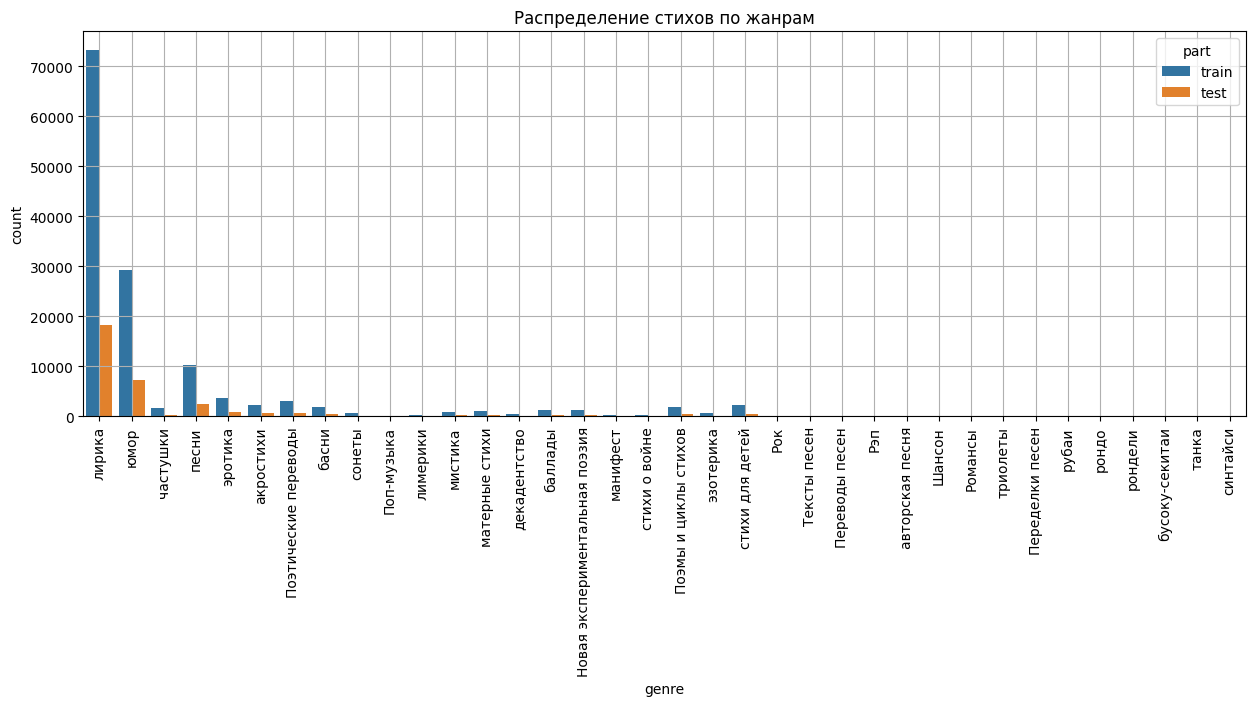

In [50]:
# топ-3 жанров
top_3_genres = train_data["genre"].value_counts().index[:3].tolist()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(
    data=pd.concat([train_data.assign(part="train"), test_data.assign(part="test")]),
    x="genre",
    hue="part",
    ax=ax,
)
ax.grid(True)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title("Распределение стихов по жанрам")
plt.show()

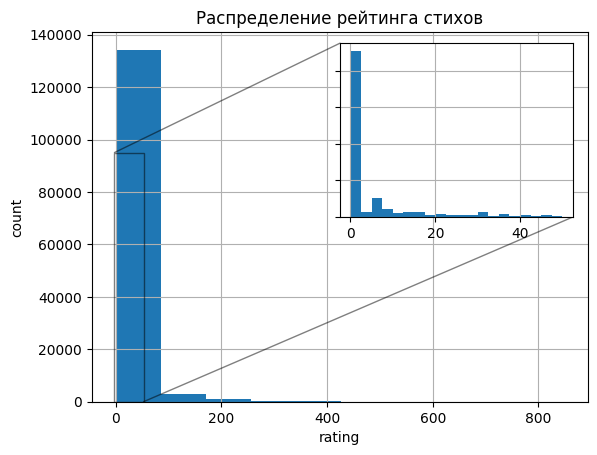

In [51]:
fig, ax = plt.subplots(1, 1)
plt.hist(train_data["rating"])
ax.grid()
ax.set_xlabel("rating")
ax.set_ylabel("count")
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47], yticklabels=[])
axins.hist(train_data["rating"], range=(0, 50), bins=20)
axins.grid()
ax.set_title("Распределение рейтинга стихов")
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.show()

Видим, что много рейтинга около 0, а точнее даже 0. При этом максимум уходит за 800.

In [52]:
train_data["rating"].value_counts(normalize=True).to_frame("Доля")

,Доля
rating,
0,0.563492
7,0.067307
2,0.053650
1,0.036779
9,0.020022
...,...
318,0.000007
398,0.000007
334,0.000007


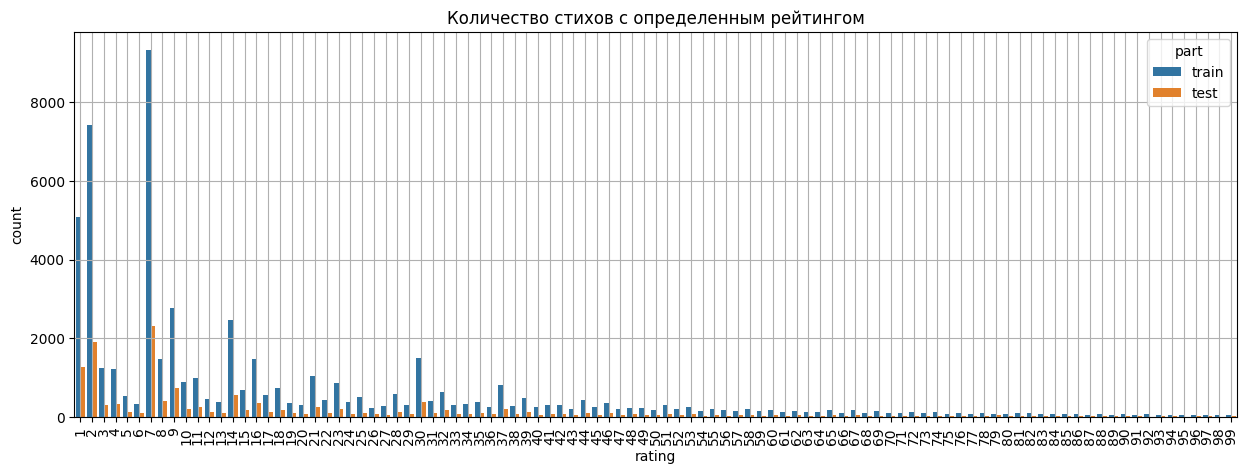

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(
    data=pd.concat([train_data.assign(part="train"), test_data.assign(part="test")]).query("rating > 0 and rating < 100"),
    x="rating",
    ax=ax,
    hue="part",
)
ax.grid(True)
ax.set_title("Количество стихов с определенным рейтингом")
ax.xaxis.set_tick_params(rotation=90)
plt.show()

In [89]:
train_data["rating"].describe()

count    138396.000000
mean         11.920265
std          32.553441
min           0.000000
25%           0.000000
50%           0.000000
75%           8.000000
max         851.000000
Name: rating, dtype: float64

* Статистики по рейтингу в зависимости от жанра (рассматриваются топ-3 жанра)

In [54]:
train_data[train_data["genre"].isin(top_3_genres)].groupby("genre").describe()

rating                                                       views  \
          count       mean        std  min  25%   50%   75%    max    count   
genre                                                                         
лирика  73285.0  12.172355  32.819731  0.0  0.0   0.0   9.0  648.0  73285.0   
песни   10379.0  33.833799  55.538392  0.0  1.0  11.0  44.0  851.0  10379.0   
юмор    29315.0   7.276377  21.629405  0.0  0.0   0.0   7.0  449.0  29315.0   

                                                                   
              mean         std   min   25%    50%    75%      max  
genre                                                              
лирика   76.862305  235.765345  10.0  19.0   39.0   81.0  47547.0  
песни   392.290587  953.970556  10.0  76.0  208.0  419.0  30984.0  
юмор    133.058878  250.326771  10.0  25.0   67.0  163.0  11218.0

Text(0.5, 1.0, 'KDE для рейтина в зависимости от жанра (Топ-3 жанра)')

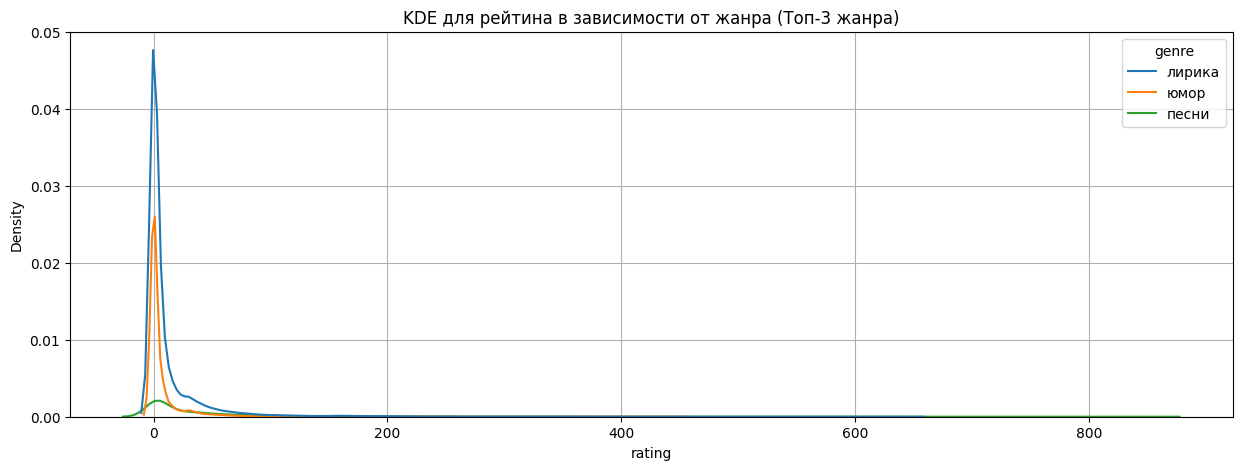

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(data=train_data[train_data["genre"].isin(top_3_genres)], x="rating", hue="genre")
ax.grid(True)
ax.set_title("KDE для рейтина в зависимости от жанра (Топ-3 жанра)")

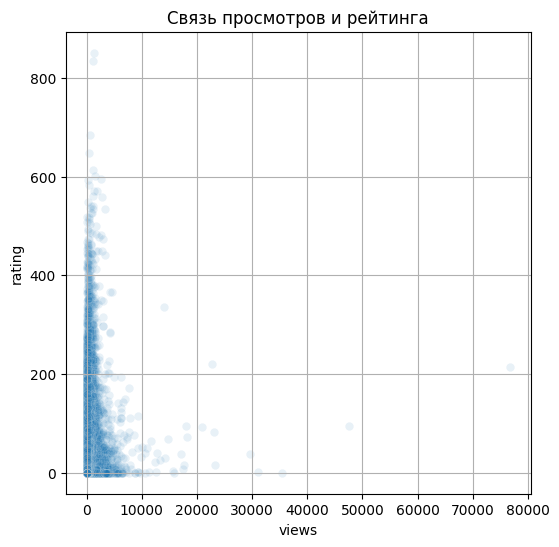

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(data=train_data, x="views", y="rating", alpha=0.1)
ax.grid(True)
ax.set_title("Связь просмотров и рейтинга")
plt.show()

In [57]:
(train_data["rating"] > train_data["views"]).mean()

0.035600739905777626

In [58]:
train_data[train_data["rating"] > train_data["views"]]

,url,rating,views,output_text,genre
9,https://www.chitalnya.ru/work/3841458/,58,16,"Чавкает лужа смешно под ногами:\nСэр, можно мн...",юмор
15,https://www.chitalnya.ru/work/3275893/,58,26,"Свод законов небесный,\nСнегопады, дожди.\nОт ...",лирика
89,https://www.chitalnya.ru/work/3439058/,73,72,"Выцветают чернила новеллы потерянной ночи,\nНа...",лирика
178,https://www.chitalnya.ru/work/3773168/,32,20,Завтра начинается вчера\nБоги существуют понар...,эзотерика
204,https://www.chitalnya.ru/work/3375714/,39,17,"Мы к берегу пологому причалим,\nОглянемся наза...",лирика
...,...,...,...,...,...
138284,https://www.chitalnya.ru/work/3800370/,48,34,"А, вот сегодняшний денёк:\nЯгуша всех достала!...",юмор
138334,https://www.chitalnya.ru/work/3694518/,82,44,"Мне знакомы, до боли знакомы\nВсе тропинки дер...",лирика
138343,https://www.chitalnya.ru/work/3720299/,45,20,Если хочешь..-А если нет?\nНе нужны пустые сло...,лирика
138357,https://www.chitalnya.ru/work/3011493/,47,40,"О чём грустят московские сосульки?\nО том, что...",песни


In [86]:
from bs4 import BeautifulSoup
import requests

top_1_url = train_data.sort_values("rating", ascending=False)["url"].iloc[0]

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
soup = BeautifulSoup(requests.get(top_1_url, headers=headers).text)
soup.title.text

'Линия жизни - Засл. арт. РСФСР В. Ярушин ~ Песни (Песни с видео)'

https://www.chitalnya.ru/work/1670945/ - по факту это песня, а не стих + текст к песне, так что на рейтинг помимо текста может влиять музыка

Также на этом примере можно увидеть, что возможно дополнительная информация, которая содержится на портале, имела бы полезный эффект:
```
Рейтинг работы: 842
Количество отзывов: 89
Количество сообщений: 94
Количество просмотров: 1395
Добавили MP3 в избранное: 3
Добавили в избранное: 4
```

Например, количество добавлений в изранной или количество отзывов можно было использовать для, например, отбора более "качественных" объектов.

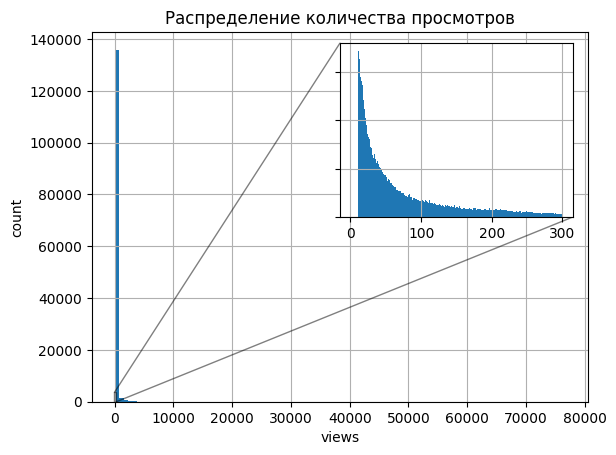

In [99]:
fig, ax = plt.subplots(1, 1)
plt.hist(train_data["views"], bins=100)
ax.grid()
ax.set_xlabel("views")
ax.set_ylabel("count")
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47], yticklabels=[])
axins.hist(train_data["views"], range=(0, 300), bins=300)
axins.grid()
ax.set_title("Распределение количества просмотров")
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.show()